In [1]:
"""
🧠 Brain Tumor Classification Dataset – Model Training and Evaluation 

This notebook handles dataset exploration and preparation steps for a Vision Transformer (ViT)-based
classification task. It processes a dataset of brain MRI images, categorized into:
- Glioma
- Meningioma
- Tumor (General)

Each main class contains multiple subfolders with various image enhancement techniques 
(e.g., heatmap visualization, edge detection).

📌 Goals:
- Traverse through the dataset and collect image metadata
- Prepare data for modeling with PyTorch or TensorFlow pipelines

📚 Libraries Used:
- os, glob: File system traversal
- cv2, PIL: Image reading and conversion
- NumPy: Array manipulation
- Pandas: Data structuring
- tqdm: Progress bar for loop visibility
- warnings: Suppress unnecessary logs
"""

# === Import Required Libraries ===
import os                                  # File path and directory handling
import cv2                                 # Image reading (as NumPy arrays)
from PIL import Image                      # Image reading via Pillow (optional for RGB mode)
import matplotlib.pyplot as plt            # Static plotting for histograms, line plots, etc.
import numpy as np                         # Numerical computations and array manipulation
from glob import glob                      # For recursive pattern-based file discovery
import pandas as pd                        # DataFrames for structured tabular data
import warnings                            # To suppress library warnings
warnings.filterwarnings('ignore')          # Ignore warning messages to keep output clean

In [2]:
# Define the base directory where the dataset is located.
# This is the root directory that contains the three main tumor categories:
# - 'glioma'
# - 'meningioma'
# - 'tumor' (likely a general or mixed type)
base_dir = "/kaggle/input/brain-cancer-mri-colorized-dataset/data"

# List all subdirectories in the base directory.
# These represent the top-level classes (tumor types).
main_classes = os.listdir(base_dir)

# Display the names of the top-level folders (tumor categories).
main_classes

['brain_tumor', 'brain_glioma', 'brain_menin']

In [3]:
# Initialize a list to store image metadata
data = []

# Traverse each class folder
for main_class in main_classes:
    class_path = os.path.join(base_dir, main_class)

    # Traverse each augmentation subfolder (e.g., 'Edge_Detection', '3D_Rendering')
    for subfolder in os.listdir(class_path):
        subfolder_path = os.path.join(class_path, subfolder)

        # Check if the path is a directory (i.e., contains images)
        if os.path.isdir(subfolder_path):
            # Get all image files inside the augmentation subfolder
            image_files = glob(os.path.join(subfolder_path, '*.*'))  # Supports jpg, png, etc.

            # Append image details to the list
            for image_path in image_files:
                data.append({
                    'class': main_class,           # e.g., 'glioma'
                    'augmentation': subfolder,     # e.g., 'Edge_Detection'
                    'image_path': image_path       # Full image path
                })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head()

,class,augmentation,image_path
0,brain_tumor,LUT_Color_Map,/kaggle/input/brain-cancer-mri-colorized-datas...
1,brain_tumor,LUT_Color_Map,/kaggle/input/brain-cancer-mri-colorized-datas...
2,brain_tumor,LUT_Color_Map,/kaggle/input/brain-cancer-mri-colorized-datas...
3,brain_tumor,LUT_Color_Map,/kaggle/input/brain-cancer-mri-colorized-datas...
4,brain_tumor,LUT_Color_Map,/kaggle/input/brain-cancer-mri-colorized-datas...


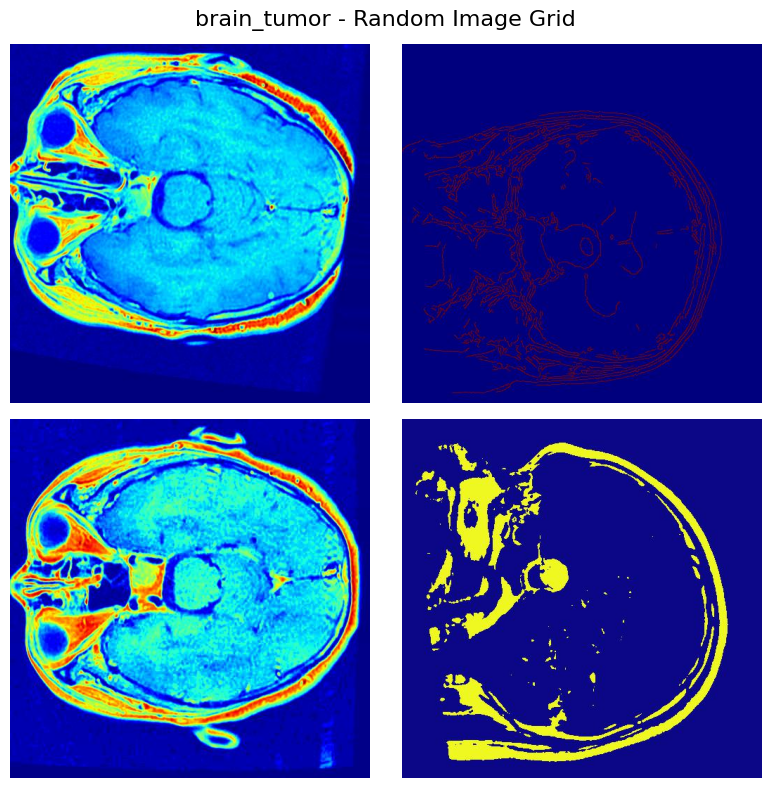

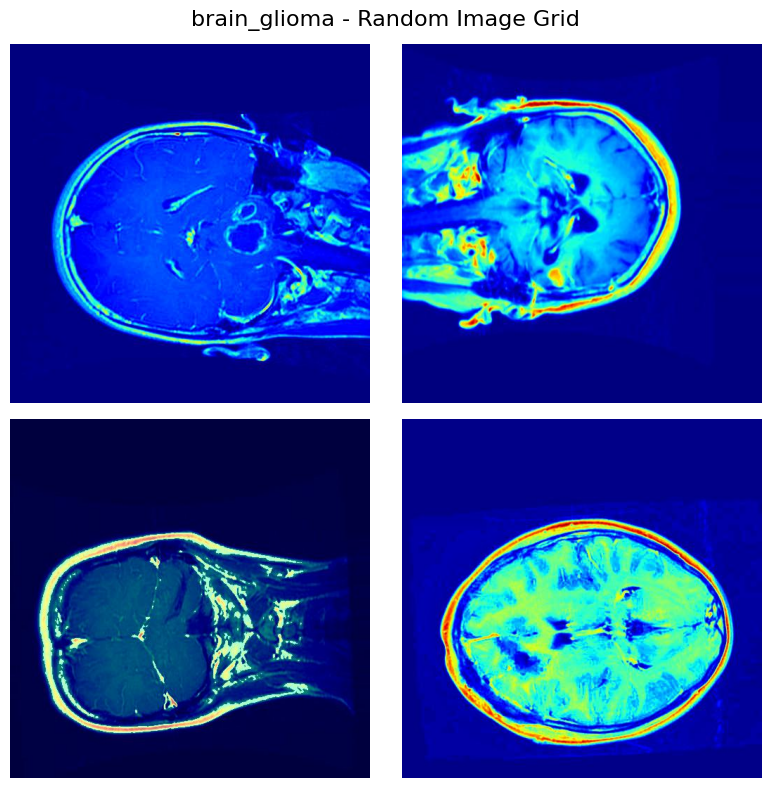

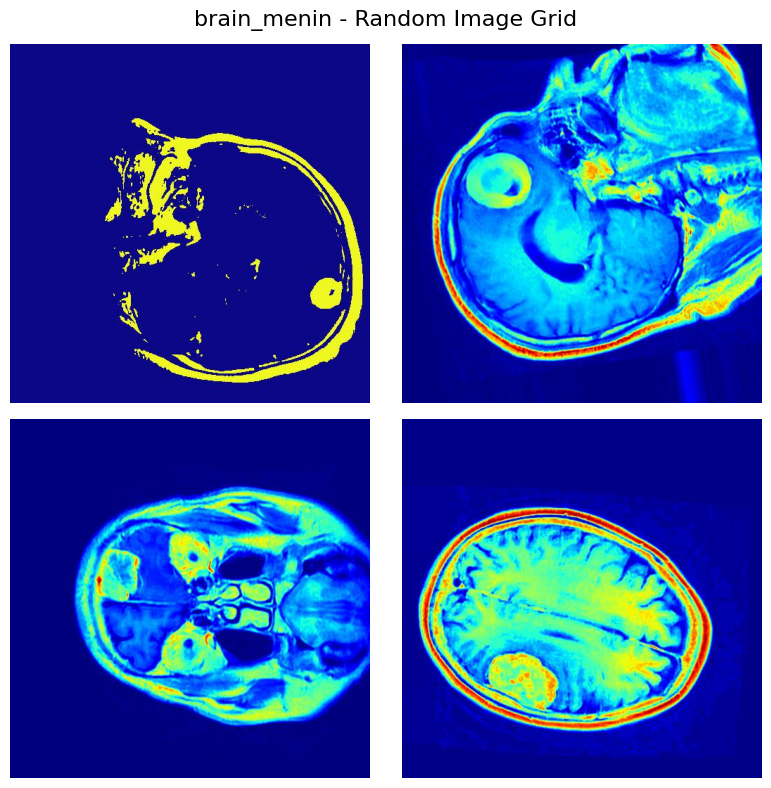

In [4]:
import random

# Function to plot a grid of random images for a given tumor class
def plot_random_grid(df, target_class, grid_size=2):
    """
    Plots a grid of randomly selected images for a given class.
    
    Parameters:
    - df (DataFrame): A DataFrame with image paths and class labels.
    - target_class (str): Class label to filter images (e.g., 'glioma').
    - grid_size (int): Grid size for displaying images (default: 3x3).
    """
    
    # Randomly sample (grid_size^2) images for the given class
    samples = df[df['class'] == target_class].sample(grid_size**2)

    # Create a grid of subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    fig.suptitle(f'{target_class} - Random Image Grid', fontsize=16)

    # Iterate over each subplot and display a sample image
    for i, ax in enumerate(axes.flat):
        # Open image from file path using PIL
        img = Image.open(samples.iloc[i]['image_path'])
        ax.imshow(img)
        ax.axis('off')  # Hide axis for cleaner display

    plt.tight_layout()
    plt.show()

# Loop over each unique class in the dataset and plot image grid
for cls in df['class'].unique():
    plot_random_grid(df, cls)

In [5]:
# Import essential libraries
import torch

# PyTorch DataLoader utilities for batching, shuffling, splitting datasets
from torch.utils.data import DataLoader, random_split

# torchvision provides common image transformations and dataset loaders
from torchvision import datasets, transforms

# timm provides access to pre-trained Vision Transformer models and others
import timm

# Standard PyTorch modules for defining model architecture, loss, optimization
import torch.nn as nn
import torch.optim as optim

# tqdm provides progress bars for loops – especially useful during training
from tqdm import tqdm

In [6]:
# Define target input size for images (as expected by ViT models like ViT-B/16)
IMG_SIZE = 224

# Define a sequence of image transformations:
# - Resize: ensures all images are of the same size
# - ToTensor: converts PIL images to PyTorch tensors (C x H x W)
# - Normalize: standardize pixel values to [-1, 1] for faster & stable training
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                            # Resize all images to 224x224
    transforms.ToTensor(),                                              # Convert to tensor format
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])     # Normalize RGB channels
])

# Define the root directory where your dataset is located
dataset_path = base_dir  # base_dir should point to the directory with 'glioma', 'meningioma', 'tumor' subfolders

# Load the dataset using ImageFolder:
# This assumes folder structure: root/class_name/image.jpg
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Get the class names detected by ImageFolder
class_names = full_dataset.classes
print("Classes:", class_names)  # Should print: ['glioma', 'meningioma', 'tumor']

# Split the dataset into training (80%) and validation (20%) sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Perform the split using random_split for reproducibility and randomness
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

Classes: ['brain_glioma', 'brain_menin', 'brain_tumor']


In [7]:
# Define the batch size for training and validation
BATCH_SIZE = 32

# Create the DataLoader for the training set
train_loader = DataLoader(
    train_dataset,           # Training dataset
    batch_size=BATCH_SIZE,   # Number of images per batch
    shuffle=True,            # Shuffle the dataset at every epoch for better generalization
    num_workers=4            # Number of subprocesses used for data loading (tune based on your hardware)
)

# Create the DataLoader for the validation set
val_loader = DataLoader(
    val_dataset,             # Validation dataset
    batch_size=BATCH_SIZE,   # Same batch size as training
    shuffle=False,           # Don't shuffle validation data
    num_workers=4            # Same number of workers as training
)

In [8]:
# Select the device to run the model on: GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pretrained Vision Transformer (ViT) base model with patch size 16 and input size 224x224
# - pretrained=True loads weights trained on ImageNet
# - num_classes = number of brain tumor classes (3 in your case)
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(class_names))

# Move the model to the selected device (GPU/CPU)
model.to(device)

# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define the optimizer (AdamW is commonly used with transformers for better regularization)
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

# Print the device to confirm where the model is running
device

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

device(type='cuda')

In [9]:
EPOCHS = 1  # Number of training epochs (increase as needed)

# // Training Loop
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    running_loss, correct = 0.0, 0  # Initialize loss and correct prediction counters

    # Iterate over batches in the training DataLoader
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)  # Move data to device (GPU/CPU)

        optimizer.zero_grad()  # Clear previous gradients before backpropagation
        outputs = model(images)  # Forward pass through the model
        loss = criterion(outputs, labels)  # Calculate loss between predicted and true labels
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights

        running_loss += loss.item()  # Accumulate loss for reporting
        correct += (outputs.argmax(1) == labels).sum().item()  # Count correct predictions in batch

    train_acc = correct / len(train_dataset)  # Calculate training accuracy
    print(f"Train Loss: {running_loss:.4f}, Accuracy: {train_acc:.4f}")  # Print training loss and accuracy

    # Validation Loop
    model.eval()  # Set model to evaluation mode (disables dropout, batchnorm updates)
    val_correct = 0  # Initialize correct prediction counter for validation

    with torch.no_grad():  # Disable gradient calculations for validation (saves memory)
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)  # Forward pass
            val_correct += (outputs.argmax(1) == labels).sum().item()  # Count correct predictions

    val_acc = val_correct / len(val_dataset)  # Calculate validation accuracy
    print(f"Validation Accuracy: {val_acc:.4f}")  # Print validation accuracy

Epoch 1/1: 100%|██████████| 1969/1969 [19:43<00:00,  1.66it/s]

Train Loss: 288.7964, Accuracy: 0.9394


Validation Accuracy: 0.9581
